In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
class Config:
    manual_seed = 999
    data_root = "afhq"
    train_dir = os.path.join(data_root, "train")
    val_dir = os.path.join(data_root, "val")
    batch_size = 64
    image_size = 64  
    nc = 3  # Liczba kanałów (RGB)
    nz = 100  # Rozmiar wektora szumu
    ngf = 128  # Wymiar filtrów generatora
    ndf = 128  # Wymiar filtrów dyskryminatora
    num_epochs = 50
    lr_g = 0.0001  # Learning rate generatora
    lr_d = 0.00004  # Learning rate dyskryminatora
    beta1 = 0.5  # Parametr beta1 dla Adam
    ngpu = 1 
    validation_interval = 200 

# Wartości dla najlepszego generowania 
    #image_size = 128      
    #nc = 3
    #nz = 100             
    #ngf = 64             
    #ndf = 64              
    #num_epochs = 50
    #lr_g = 0.0002         
    

In [ ]:
random.seed(Config.manual_seed)
torch.manual_seed(Config.manual_seed)
torch.use_deterministic_algorithms(True)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(Config.image_size),
    transforms.CenterCrop(Config.image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [ ]:
assert os.path.exists(Config.train_dir), f"Folder {Config.train_dir} nie istnieje!"
assert os.path.exists(Config.val_dir), f"Folder {Config.val_dir} nie istnieje!"

In [ ]:
train_dataset = dset.ImageFolder(root=Config.train_dir, transform=transform)
val_dataset = dset.ImageFolder(root=Config.val_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=Config.batch_size)

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and Config.ngpu > 0) else "cpu")
print(f"Używane urządzenie: {device}")

In [ ]:
# Inicjalizacja wag
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(Config.nz, Config.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(Config.ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(Config.ngf * 8, Config.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(Config.ngf * 4, Config.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(Config.ngf * 2, Config.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(Config.ngf, Config.nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Dyskryminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(Config.nc, Config.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(Config.ndf, Config.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(Config.ndf * 2, Config.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(Config.ndf * 4, Config.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(Config.ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Inicjalizacja modeli
netG = Generator(Config.ngpu).to(device)
netD = Discriminator(Config.ngpu).to(device)

if (device.type == 'cuda') and (Config.ngpu > 1):
    netG = nn.DataParallel(netG, list(range(Config.ngpu)))
    netD = nn.DataParallel(netD, list(range(Config.ngpu)))

netG.apply(weights_init)
netD.apply(weights_init)

# Funkcja straty i optymalizatory
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, Config.nz, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0

optimizerD = optim.Adam(netD.parameters(), lr=Config.lr_d, betas=(Config.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=Config.lr_g, betas=(Config.beta1, 0.999))


In [ ]:
# Funkcja walidacji
def validate():
    netG.eval()
    netD.eval()
    
    val_loss_G = 0.0
    val_loss_D = 0.0
    
    with torch.no_grad():
        for i, (real_images, _) in enumerate(val_loader, 0):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            
            # Dyskryminator na prawdziwych obrazach
            label = torch.full((batch_size,), real_label, device=device)
            output = netD(real_images).view(-1)
            errD_real = criterion(output, label)
            
            # Dyskryminator na fałszywych obrazach
            noise = torch.randn(batch_size, Config.nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            
            # Generator
            label.fill_(real_label)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            
            val_loss_D += (errD_real + errD_fake).item()
            val_loss_G += errG.item()
    
    return val_loss_D / len(val_loader), val_loss_G / len(val_loader)

In [ ]:
# Trening
img_list = []
G_losses = []
D_losses = []
val_G_losses = []
val_D_losses = []
iters = 0

print("Rozpoczęcie treningu...")
for epoch in range(Config.num_epochs):
    netG.train()
    netD.train()
    
    for i, (real_images, _) in enumerate(train_loader, 0):
        ############################
        # (1) Aktualizacja D
        ###########################
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        
        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, Config.nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Aktualizacja G
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Zapis strat
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Walidacja
        if iters % Config.validation_interval == 0:
            val_D, val_G = validate()
            val_D_losses.append(val_D)
            val_G_losses.append(val_G)
            print(f"[{epoch}/{Config.num_epochs}][{i}/{len(train_loader)}] Val_D: {val_D:.4f}, Val_G: {val_G:.4f}")
            
            netG.train()
            netD.train()

        # Zapis przykładowych wyników
        if (iters % 500 == 0) or ((epoch == Config.num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    
    val_D, val_G = validate()
    print(f"Epoka {epoch} zakończona | Val Loss D: {val_D:.4f} | Val Loss G: {val_G:.4f}")

print("Trening zakończony!")

Używane urządzenie: cuda:0
Rozpoczęcie treningu...
[0/50][0/81] Val_D: 1.3500, Val_G: 0.7817
Epoka 0 zakończona | Val Loss D: 8.4309 | Val Loss G: 1.8610
Epoka 1 zakończona | Val Loss D: 8.7576 | Val Loss G: 0.4225
[2/50][38/81] Val_D: 10.3784, Val_G: 1.6582
Epoka 2 zakończona | Val Loss D: 7.6671 | Val Loss G: 3.1790
Epoka 3 zakończona | Val Loss D: 9.4722 | Val Loss G: 0.7890
[4/50][76/81] Val_D: 1.1193, Val_G: 2.1662
Epoka 4 zakończona | Val Loss D: 1.1177 | Val Loss G: 1.3975
Epoka 5 zakończona | Val Loss D: 1.5645 | Val Loss G: 1.5603
Epoka 6 zakończona | Val Loss D: 0.8380 | Val Loss G: 1.7938
[7/50][33/81] Val_D: 1.2035, Val_G: 1.5627
Epoka 7 zakończona | Val Loss D: 1.2086 | Val Loss G: 1.2153
Epoka 8 zakończona | Val Loss D: 1.5246 | Val Loss G: 1.3712
[9/50][71/81] Val_D: 1.8295, Val_G: 0.8335
Epoka 9 zakończona | Val Loss D: 1.4098 | Val Loss G: 0.7718
Epoka 10 zakończona | Val Loss D: 2.1116 | Val Loss G: 0.5707
Epoka 11 zakończona | Val Loss D: 1.0875 | Val Loss G: 1.3937


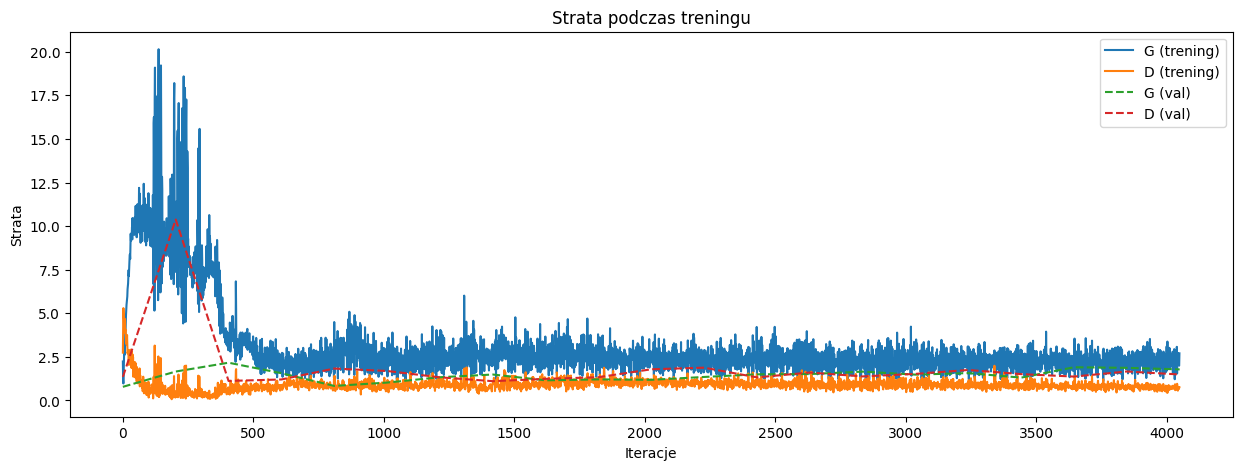

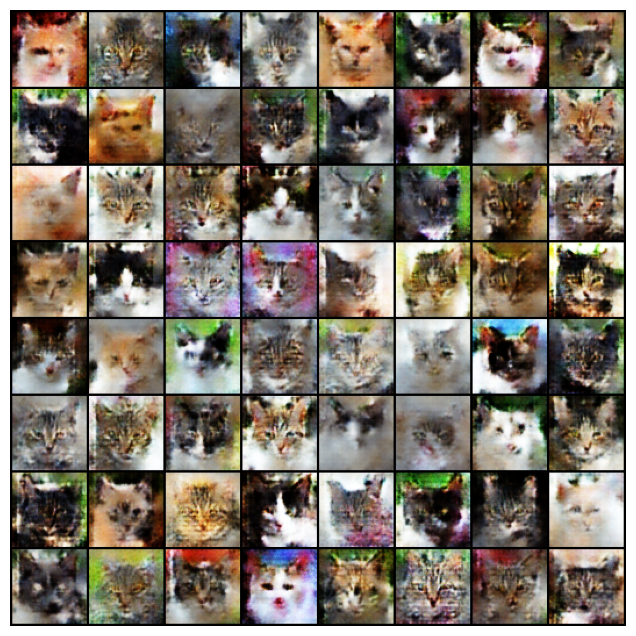

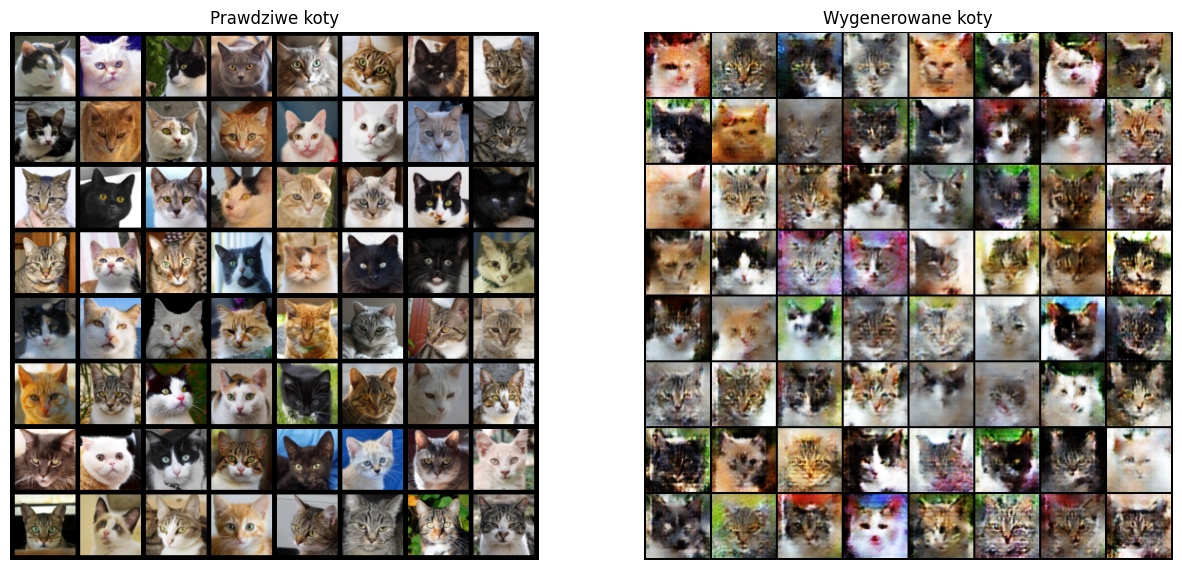

In [4]:
# Wizualizacja wyników
plt.figure(figsize=(15,5))
plt.title("Strata podczas treningu")
plt.plot(G_losses, label="G (trening)")
plt.plot(D_losses, label="D (trening)")
plt.plot(np.linspace(0, len(G_losses), len(val_G_losses)), val_G_losses, '--', label="G (val)")
plt.plot(np.linspace(0, len(D_losses), len(val_D_losses)), val_D_losses, '--', label="D (val)")
plt.xlabel("Iteracje")
plt.ylabel("Strata")
plt.legend()
plt.show()

# Animacja postępów
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

# Porównanie prawdziwych i wygenerowanych obrazów
real_batch = next(iter(train_loader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Prawdziwe koty")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Wygenerowane koty")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()